In [1]:
import pandas as pd
pd.set_option('max_column', None)
pd.set_option('display.float_format',lambda x:'%5f'%x)

import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("../data/impression_log.csv")
df.sample(5)

,Unnamed: 0,LogEntryTime,AdvertiserId,CampaignId,AdGroupId,AudienceID,CreativeId,AdFormat,Frequency,Site,FoldPosition,Country,Region,City,DeviceType,OSFamily,OS,Browser,DeviceMake,AdvertiserCurrency,click,engagement,video-end,video-start
55551,37a3ad1b-a464-4394-a5ce-d0e24b7711c4,2021-09-24 20:36:18,868ko1s,t29si1w,e9qf2dm,0,lconq2bf,300x250,0,oldworldgardenfarms.com,2,United States,New York,Staten Island,4,5.000000,174.000000,15.000000,Apple,0.007190,0,0,0,0
11949,0bb036fb-46ef-4021-a085-182f0dc2c44f,2021-09-27 12:49:03,868ko1s,awbu4q4,oropida,lnqjhqm,n8qm1pum,300x250,0,www.thesun.ie,4,United States,New York,The Bronx,4,6.000000,156.000000,6.000000,Nokia,0.008240,0,0,0,0
21964,15db3742-05d3-4cd6-a187-1a91e7771252,2021-09-21 19:07:19,868ko1s,758ifo0,6zrhqkk,0,bgkw47cl,300x250,0,lifestyleofafoodie.com,2,United States,Pennsylvania,Morgantown,4,5.000000,174.000000,7.000000,Apple,0.007123,0,0,0,0
49812,31e2a3cb-2378-4aab-ba6b-3c34f2d74c82,2021-09-26 11:53:48,868ko1s,shg01yl,ckz8efm,0,c8zbwnc7,300x250,0,www.fox4now.com,2,United States,New Hampshire,Brookline,4,5.000000,101.000000,7.000000,Apple,0.007444,0,0,0,0
10033,09cdd8e6-c142-4225-adb0-8e376878f843,2021-09-22 17:52:37,868ko1s,t29si1w,q8mek2e,0,4i46fl6r,320x480,0,www.imore.com,4,United States,New Jersey,Highland Lakes,4,5.000000,174.000000,7.000000,Apple,0.006676,0,1,1,1


* A **campaign** is an ad placement session for a single client and single product. 
* The **campaignId** is used to distinguish different campaigns. 
* Within a single campaign, there could be multiple strategies who are served under what is called an **adgroup**

In [3]:
#Finding number of unique values per column
df.T.apply(lambda x: x.nunique(),axis=1)

Unnamed: 0            99986
LogEntryTime          89751
AdvertiserId              1
CampaignId               13
AdGroupId                25
AudienceID                6
CreativeId              282
AdFormat                  2
Frequency                 1
Site                   8538
FoldPosition              3
Country                   1
Region                   11
City                   1295
DeviceType                3
OSFamily                  6
OS                       49
Browser                   8
DeviceMake              130
AdvertiserCurrency    55156
click                     2
engagement                2
video-end                 2
video-start               2
dtype: int64

In [4]:
df.shape

(100000, 24)

In [5]:
#checking duplicates since the id column should be a unique identifier for each row
df.rename(columns={'Unnamed: 0':'Id'},inplace=True)
sum(df.duplicated(subset='Id'))==0

False

In [6]:
#drop the duplicates
df.drop_duplicates(subset = "Id", keep = False, inplace = True)

#confirm there are no more duplicates
sum(df.duplicated(subset='Id'))==0

True

**Dealing with null values**

In [7]:
#Returns columns which have null values and their respective counts of null values
df[df.columns[df.isnull().any()]].isnull().sum()

AudienceID    3454
Region           1
City             1
OSFamily         5
OS               7
Browser          7
DeviceMake       7
dtype: int64

* The data has 99,972 rows and 24 columns
* A couple of columns have null values, but nothing above 80% of the data
* Since all the columns with missing values are categorical features, we replace the null values with the most frequently occuring value

In [8]:
df.AudienceID.describe()

count       96518
unique          6
top       lnqjhqm
freq        49956
Name: AudienceID, dtype: object

<AxesSubplot:xlabel='AudienceID', ylabel='count'>

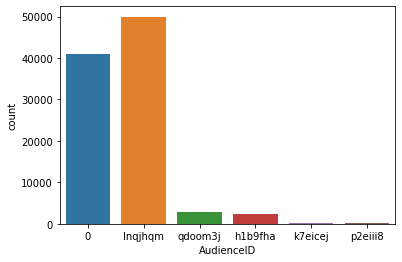

In [9]:
sns.countplot(df.AudienceID)

Assuming AudienceID describes the target audience for each campaign, replacing the null values with the most frequently occuring value could give us inaccurate results
Given we have ~99,900 rows of data we can drop these rows

For the rest of the columns we replace the null values with the most frequently occurring value

In [10]:
df = df[df.AudienceID.notna()]
df.AudienceID.isnull().any()

False

In [11]:
cols = df.columns[df.isnull().any()].to_list()
for i in cols:
    df[i].fillna(df[i].value_counts().idxmax(),inplace=True)

print("Number of remaining null values in the dataframe is",(df.isnull().sum()).sum())

Number of remaining null values in the dataframe is 0


In [12]:
data = df.groupby("Site").agg({"Site":"count","engagement":"sum"}).rename(columns={"Site":"#impressions"}).reset_index()
data["ER"]=data["#impressions"]/data.engagement

data.head()

,Site,#impressions,engagement,ER
0,1007nashicon.com,2,0,inf
1,100krecipes.com,14,0,inf
2,1057thehawk.com,4,0,inf
3,10babygear.com,1,0,inf
4,130point.com,3,0,inf


In [13]:
'''there are infinite values in the ER column since we divided #impressions by zero meaning the ad on the specific
site had no engagement'''
data.ER.isin([np.inf,-np.inf]).any()

#Replace inf with 0
data.ER = data.ER.replace([np.inf,-np.inf],0)

In [14]:
#create a dictionary with Site as keys and engagement rate as values so as to map on new ER column
engage = pd.Series(data.ER.values,index=data.Site).to_dict()
df['engagement_rate'] = df['Site'].apply(lambda x:engage[x])

#generate date features
df.rename(columns = {"LogEntryTime":"date"}, inplace = True)
df.date = pd.to_datetime(df.date)
df['hour'] = pd.Series(df.date.dt.hour)
df.drop(["date","Country","AdvertiserId","Frequency","Country","Id"],axis = 1, inplace = True)

In [15]:
df.head()

,CampaignId,AdGroupId,AudienceID,CreativeId,AdFormat,Site,FoldPosition,Region,City,DeviceType,OSFamily,OS,Browser,DeviceMake,AdvertiserCurrency,click,engagement,video-end,video-start,engagement_rate,hour
0,t29si1w,e9qf2dm,0,9wkrkl5j,300x250,scrabblewordfinder.org,4,New York,Staten Island,4,5.000000,173.000000,7.000000,Apple,0.006409,0,0,0,0,0.000000,0
1,fiwemi8,8m750eh,0,zhre4utp,300x250,www.thecoli.com,2,Massachusetts,Milton,4,5.000000,173.000000,7.000000,Apple,0.002778,0,0,0,0,0.000000,2
2,awbu4q4,oropida,lnqjhqm,ab6spdyi,300x250,www.today.com,3,New York,Brooklyn,4,6.000000,156.000000,6.000000,Samsung,0.008947,0,0,0,0,16.000000,20
3,t29si1w,e9qf2dm,0,2spj6krt,300x250,www.cbssports.com,4,New York,Queens,4,5.000000,101.000000,7.000000,Apple,0.007673,0,0,0,0,3.342569,16
4,awbu4q4,oropida,lnqjhqm,ql1q5nq9,300x250,backroadramblers.com,3,New York,The Bronx,4,5.000000,101.000000,7.000000,Apple,0.008852,0,1,1,1,5.000000,14


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96518 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CampaignId          96518 non-null  object 
 1   AdGroupId           96518 non-null  object 
 2   AudienceID          96518 non-null  object 
 3   CreativeId          96518 non-null  object 
 4   AdFormat            96518 non-null  object 
 5   Site                96518 non-null  object 
 6   FoldPosition        96518 non-null  int64  
 7   Region              96518 non-null  object 
 8   City                96518 non-null  object 
 9   DeviceType          96518 non-null  int64  
 10  OSFamily            96518 non-null  float64
 11  OS                  96518 non-null  float64
 12  Browser             96518 non-null  float64
 13  DeviceMake          96518 non-null  object 
 14  AdvertiserCurrency  96518 non-null  float64
 15  click               96518 non-null  int64  
 16  enga

In [17]:
#save data before encoding
df.to_csv('../data/ad_data.csv')

In [18]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()

num_columns = df.select_dtypes(include = ["int64","float64"]).columns
cat_columns = df.select_dtypes(include = ["object"]).columns

#skip the CampaignId column
for i in cat_columns:
    if i == 'CampaignId' or i == 'Site':
        pass
    else:
        df[i]=le.fit_transform(df[i].astype(str))

In [19]:
#data after encoding
df.to_csv("../data/clean_data.csv",index=False)

In [20]:
df.sample(5)

,CampaignId,AdGroupId,AudienceID,CreativeId,AdFormat,Site,FoldPosition,Region,City,DeviceType,OSFamily,OS,Browser,DeviceMake,AdvertiserCurrency,click,engagement,video-end,video-start,engagement_rate,hour
18999,t29si1w,12,0,25,0,www.spendwithpennies.com,4,6,893,3,6.000000,154.000000,6.000000,75,0.007961,0,0,0,0,14.833333,16
51265,awbu4q4,18,3,80,0,nypost.com,3,7,1127,4,6.000000,162.000000,6.000000,32,0.011065,0,0,0,0,5.612613,6
37159,awbu4q4,18,3,212,0,www.familycantravel.com,2,7,764,4,6.000000,162.000000,6.000000,75,0.009164,0,0,0,0,0.000000,10
85235,awbu4q4,18,3,164,0,www.getyourholidayon.com,3,6,706,4,5.000000,174.000000,7.000000,8,0.009532,0,0,0,0,0.000000,4
55003,awbu4q4,18,3,218,0,insidethemagic.net,3,6,193,4,6.000000,162.000000,6.000000,75,0.009981,0,0,0,0,9.052632,2


In [21]:
#Finding number of unique values per column
df.T.apply(lambda x: x.nunique(),axis=1)

CampaignId               13
AdGroupId                25
AudienceID                6
CreativeId              282
AdFormat                  2
Site                   8407
FoldPosition              3
Region                   11
City                   1291
DeviceType                3
OSFamily                  6
OS                       49
Browser                   8
DeviceMake              130
AdvertiserCurrency    54167
click                     2
engagement                2
video-end                 2
video-start               2
engagement_rate         386
hour                     24
dtype: int64

In [22]:
df.columns

Index(['CampaignId', 'AdGroupId', 'AudienceID', 'CreativeId', 'AdFormat',
       'Site', 'FoldPosition', 'Region', 'City', 'DeviceType', 'OSFamily',
       'OS', 'Browser', 'DeviceMake', 'AdvertiserCurrency', 'click',
       'engagement', 'video-end', 'video-start', 'engagement_rate', 'hour'],
      dtype='object')

<h2> Task 1 </h2>

Write a function that:

- Accepts a campaignId as an input
- Filters the data by the campaignId provided
- Assign a score to each site
- Sort the data by the assigned score

In [23]:
sc = StandardScaler()
model = LogisticRegression()
def site_scores(campaignid:str):
    campaign = df.loc[df['CampaignId']== campaignid]
    campaign.drop(['CampaignId'],axis = 1, inplace = True)
    site = campaign.groupby('Site').agg({'AdGroupId':'mean','AudienceID':'mean','AdFormat':'mean','FoldPosition':'mean', 'Region':'mean', 
                          'City':'mean', 'DeviceType':'mean', 'OSFamily':'mean', 'OS':'mean','Browser':'mean',
                          'DeviceMake':'mean', 'AdvertiserCurrency':'mean', 'click':'mean', 'engagement':'mean',
                          'video-end':'mean', 'video-start':'mean', 'engagement_rate':'mean', 'hour':'mean'}).reset_index()
    #site.drop('Site',axis = 1, inplace = True)
    site.loc[site['engagement'] < 0.5, 'engagement'] = 0
    site.loc[site['engagement'] >= 0.5, 'engagement'] = 1
    X = site.drop(['engagement','Site'], axis = 1)
    X = sc.fit_transform(X)
    y = site['engagement']
    model.fit(X,y)
    scores = 100*(model.predict_proba(X)[:,1])

    sites =pd.DataFrame(site.Site)
    score = pd.DataFrame(scores)
    data = pd.concat([sites,score],axis = 1)
    data.columns = ['Site','Score']
    data.Score = data.Score.round(2)
    data.sort_values(by = 'Score', ascending = False, inplace = True)
    data.reset_index(drop = True,inplace = True)
    return data

In [24]:
df.CampaignId.unique()

array(['t29si1w', 'fiwemi8', 'awbu4q4', 'v0fbymt', 'dnpjc6c', '9n6o7jf',
       '758ifo0', 'shg01yl', '8muucqy', 'xygdmea', '0k2sw7w', 'z5cjizq',
       '5qtwg2a'], dtype=object)

In [25]:
out =site_scores('fiwemi8')
put=out.apply(lambda x: x.to_json(), axis=1)
put

0              {"Site":"eso-sets.com","Score":100.0}
1         {"Site":"bakingamoment.com","Score":100.0}
2            {"Site":"www.entoin.com","Score":100.0}
3           {"Site":"www.eatperu.com","Score":100.0}
4          {"Site":"www.inquirer.com","Score":100.0}
                           ...                      
833           {"Site":"dailycannon.com","Score":0.0}
834         {"Site":"altarofgaming.com","Score":0.0}
835     {"Site":"sidehustlingmoney.com","Score":0.0}
836    {"Site":"thisitaliankitchen.com","Score":0.0}
837        {"Site":"whatsdavedoing.com","Score":0.0}
Length: 838, dtype: object